In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import qiskit
from qiskit import QuantumCircuit #Aer, IBMQ,
from qiskit.visualization import plot_histogram
from qiskit import transpile
#from qiskit.providers import fake_provider
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeTorino, FakeBrisbane
from qiskit_ibm_runtime.fake_provider import FakeFez, FakeMarrakesh
#fez, marrakesh are both Heron2
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


In [2]:
import data_extract_funcs
import meta_dataframe_functions

## Meta_data dataframe

## Measuring sparsity of data

In [5]:
hdwr_8q_tor1 = pd.read_csv("../Hardware_results/8q/8q_torino1.csv")

In [7]:
non_null_vals = hdwr_8q_tor1.count()
print(non_null_vals)

00000000    50
00000001    50
00000010    50
00000011    50
00000100    50
            ..
11111011    28
11111100     4
11111101    12
11111110    38
11111111    50
Length: 256, dtype: int64


checking the percentage_non_zero for all data

1. make file names
2. extract nr qubits etc from file names
3. add directory to file names
4. load as df, get percentage non_null

Add results dataframes into meta_dataframe...

In [ ]:
def add_df_column(meta_df):
    meta_df['df'] = meta_df['file_path'].apply(pd.read_csv)
    return meta_df
def get_percentage_non_zero(df):
    df.replace(0,'')
    percentage_non_zero = 100*sum(df.count())/(df.size)
    return percentage_non_zero

def add_sparsity_column(meta_df): #df column must already exist
    meta_df['percent_non_zero']=meta_df['df'].apply(get_percentage_non_zero)
    return meta_df

def get_experiment_type(file_path):
    if 'Hardware' in file_path:
        exp_type = 'Hardware'
        return exp_type
    if 'Refreshed' in file_path:
        exp_type = 'Refreshed Sim'
        return exp_type
    if 'Simulated' in file_path:
        exp_type = 'Sim'
        return exp_type

def add_experiment_type_column(meta_df):
    meta_df['experiment_type']=meta_df['file_path'].apply(get_experiment_type)


In [5]:
df_Refr_Sim = meta_dataframe_functions.blank_meta_df()
df_Sim =meta_dataframe_functions.blank_meta_df()
df_Hardware = meta_dataframe_functions.blank_meta_df()

meta_dataframe_functions.load_meta_df(df_Refr_Sim,'Refreshed_Simulation')
meta_dataframe_functions.load_meta_df(df_Sim,'Simulation')
meta_dataframe_functions.load_meta_df(df_Hardware,'Hardware')
#df_meta_data.head(20)


dfs_all = pd.concat([df_Refr_Sim,df_Sim,df_Hardware])
add_df_column(dfs_all)
add_sparsity_column(dfs_all)
add_experiment_type_column(dfs_all)


In [10]:

dfs_all.head(5)

,nr_qubits,backend,sim,circuit_type,file_path,df,percent_non_zero,experiment_type
0,4,torino,True,1,../Refreshed_Simulated_results/4q/4q_fake_tori...,0000 0001 0010 0011 0100 0101 0110 ...,32.4375,Refreshed Sim
1,4,torino,True,2,../Refreshed_Simulated_results/4q/4q_fake_tori...,0000 0001 0010 0011 0100 0101 0110 ...,33.8750,Refreshed Sim
2,4,torino,True,3,../Refreshed_Simulated_results/4q/4q_fake_tori...,0000 0001 0010 0011 0100 0101 0110 ...,32.5000,Refreshed Sim
3,4,brisbane,True,1,../Refreshed_Simulated_results/4q/4q_fake_bris...,0000 0001 0010 0011 0100 0101 0110 ...,38.3750,Refreshed Sim
4,4,brisbane,True,2,../Refreshed_Simulated_results/4q/4q_fake_bris...,0000 0001 0010 0011 0100 0101 0110 ...,40.0000,Refreshed Sim


In [ ]:
#move file_path and df column to end
#df_meta_data[list(('nr_qubits','backend','sim','circuit_type','percent_non_zero','experiment_type','file_path','df'))]

## Plotting sparsity things

In [9]:
import seaborn as sns

<Axes: xlabel='backend', ylabel='percent_non_zero'>

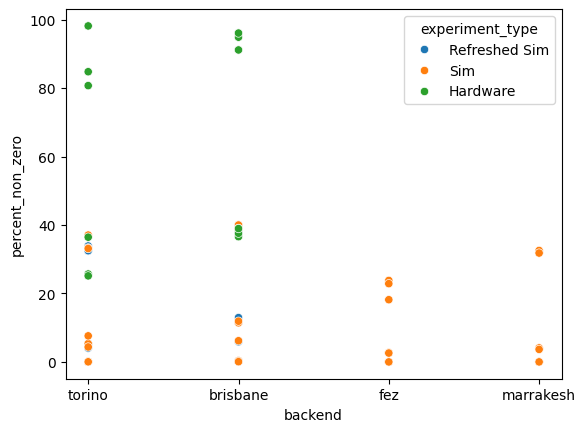

In [25]:
sns.scatterplot(dfs_all,x= "backend", y= "percent_non_zero", hue = "experiment_type")

<Axes: xlabel='circuit_type', ylabel='percent_non_zero'>

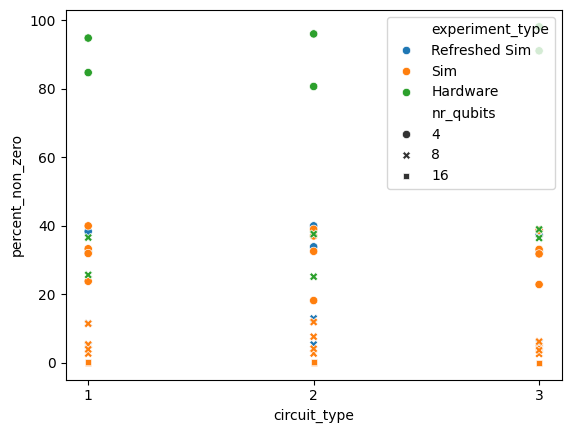

In [24]:
sns.scatterplot(dfs_all,x= "circuit_type", y= "percent_non_zero",hue = "experiment_type", style = "nr_qubits")


<Axes: xlabel='backend', ylabel='percent_non_zero'>

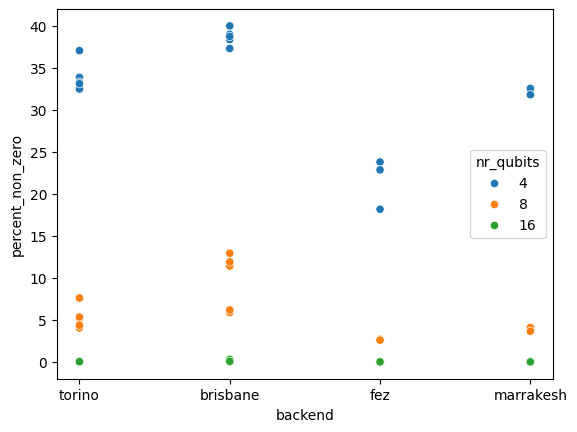

In [27]:
#dfs_all[dfs_all["sim"]==True].plot(x= "backend", y= "percent_non_zero",kind = "scatter")
sns.scatterplot(dfs_all[dfs_all["sim"]==True],x= "backend", y= "percent_non_zero", hue = "nr_qubits")

<Axes: xlabel='experiment_type', ylabel='percent_non_zero'>

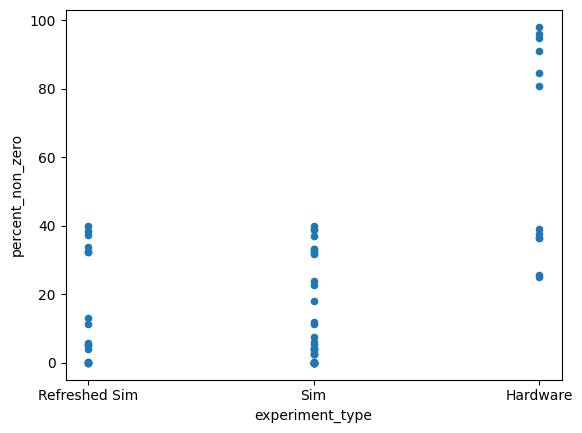

In [15]:
dfs_all.plot(x= "experiment_type", y= "percent_non_zero",kind = "scatter")


<Axes: xlabel='nr_qubits', ylabel='percent_non_zero'>

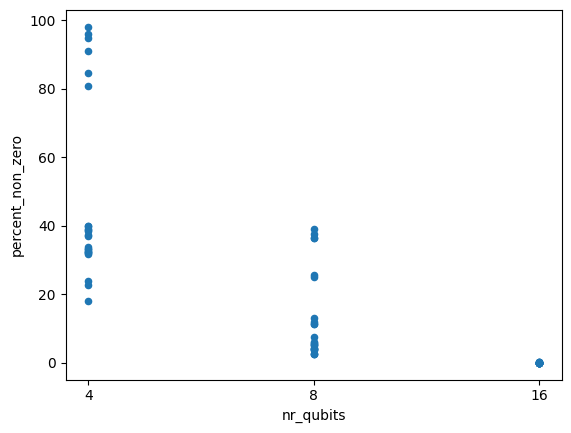

In [ ]:
dfs_all.plot(x= "nr_qubits", y= "percent_non_zero",kind = "scatter")


## Testing different methods for dealing with sparsity
### Removing null columns

### PCA

In [ ]:
#https://note.nkmk.me/en/python-numpy-zeros-ones-full/